# Severe Weather - Modeling

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as plticker
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import lightgbm as lgb
from lightgbm import LGBMRegressor
from numpy import mean
from numpy import std
from functools import partial
%matplotlib inline
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats

from sklearn.datasets import fetch_openml
from sklearn import linear_model, preprocessing, tree, svm, datasets, metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_tweedie_deviance, make_scorer


import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import warnings
from subprocess import call
from IPython.display import Image
from datetime import datetime, timedelta, date
import os
import plotly.graph_objects as go
import itertools
from io import StringIO  
import pydotplus

# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
color_choice4 = 'blue'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer

## Load the data



In [2]:
# load the data
X_train = pd.read_parquet("../Data/X_train.pqt")
X_test = pd.read_parquet("../Data/X_test.pqt")
y_train = pd.read_parquet("../Data/y_train.pqt") 
y_test = pd.read_parquet("../Data/y_test.pqt")

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

eval_set = [(X_train, y_train), (X_test, y_test)]

#df = pd.read_parquet("../Data/all_storm_data11.pqt")

# <font color='orange'>Random Forest Model</font>


In [3]:
#rf_reg = RandomForestRegressor(**random_search.best_params_, random_state=1234)
rf_reg = RandomForestRegressor(random_state=1234, n_estimators=100, n_jobs=-1)
rf_reg.fit(X_train, y_train.values.ravel())

y_pred = rf_reg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = rf_reg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

TRAIN:
MAE:  22,960,527.3
MSE:  13,156,915,872,691,156.0
RMSE: 114,703,600.1
MAPE:  1.2

TEST:
MAE:  72,924,813.1
MSE:  102,246,558,915,646,400.0
RMSE: 319,760,158.4
MAPE:  3.5

MAE DIFF: 218%


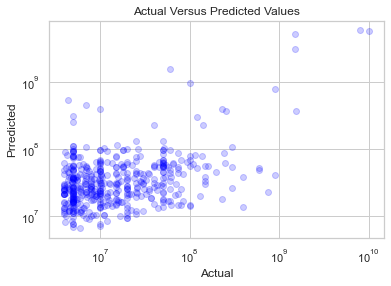

In [4]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

16


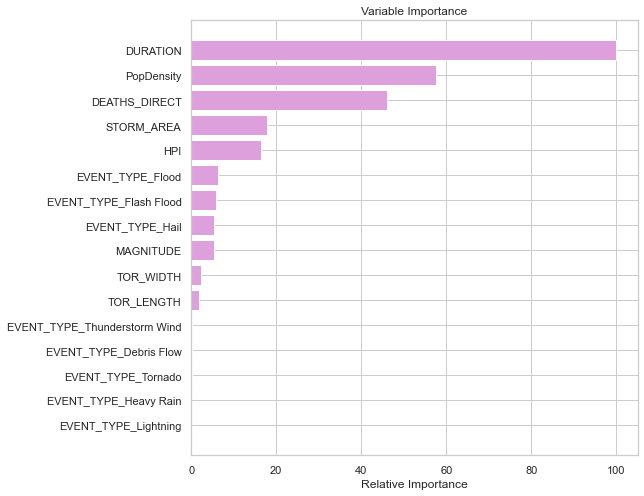

In [5]:
feature_importance = rf_reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Now hyperparameter tuning

In [6]:
# set the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

In [7]:
#markdown since it takes so long to run
# %%time
# random_search = RandomizedSearchCV(RandomForestRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [8]:
rf_reg_cv = RandomForestRegressor(max_depth=6, max_features=None, min_samples_leaf=10,
                      n_estimators=150, random_state=1234, n_jobs=-1)
rf_reg_cv.fit(X_train, y_train.values.ravel())

y_pred = rf_reg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = rf_reg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

TRAIN:
MAE:  60,296,257.4
MSE:  82,164,255,558,537,808.0
RMSE: 286,643,080.4
MAPE:  3.2

TEST:
MAE:  87,250,961.4
MSE:  270,417,517,551,690,208.0
RMSE: 520,016,843.5
MAPE:  4.2

MAE DIFF: 45%


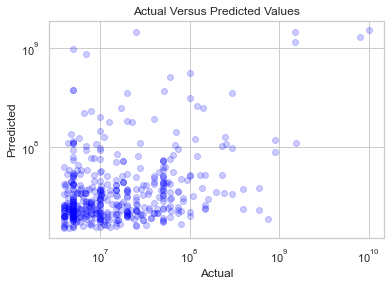

In [9]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

16


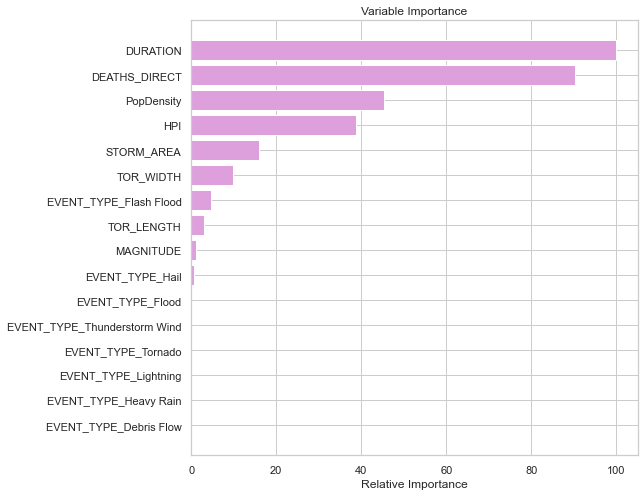

In [10]:
feature_importance = rf_reg_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>Light GBM</font>

In [11]:
# define the model
lgbm = LGBMRegressor(random_state=1234)
lgbm.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = lgbm.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[1]	training's l2: 1.03358e+17	valid_1's l2: 3.55945e+17
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 1.00666e+17	valid_1's l2: 3.518e+17
[3]	training's l2: 9.84225e+16	valid_1's l2: 3.44371e+17
[4]	training's l2: 9.65123e+16	valid_1's l2: 3.40045e+17
[5]	training's l2: 9.48329e+16	valid_1's l2: 3.34193e+17
[6]	training's l2: 9.33102e+16	valid_1's l2: 3.28667e+17
[7]	training's l2: 9.2011e+16	valid_1's l2: 3.2411e+17
[8]	training's l2: 9.07951e+16	valid_1's l2: 3.19358e+17
[9]	training's l2: 8.96906e+16	valid_1's l2: 3.20577e+17
[10]	training's l2: 8.86244e+16	valid_1's l2: 3.16414e+17
[11]	training's l2: 8.76488e+16	valid_1's l2: 3.15507e+17
[12]	training's l2: 8.67528e+16	valid_1's l2: 3.12188e+17
[13]	training's l2: 8.5154e+16	valid_1's l2: 3.06325e+17
[14]	training's l2: 8.42784e+16	valid_1's l2: 3.07943e+17
[15]	training's l2: 8.29933e+16	valid_1's l2: 3.02993e+17
[16]	training's l2: 8.21665e+16	valid_1's l2: 2.9988e+17
[17]	training's l2: 8.1046

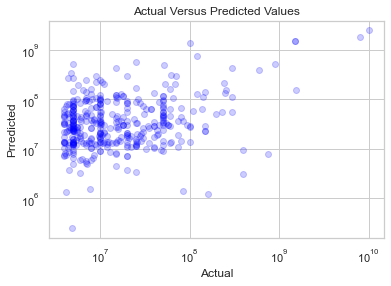

In [12]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

16


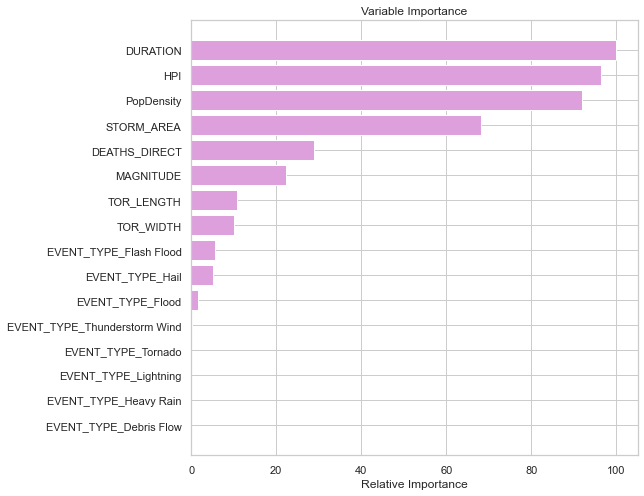

In [13]:
feature_importance = lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

With this baseline, let's see how we can improve with hyperparameter tuning

In [14]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'num_leaves': [10, 30, 50],
    'colsample_bytree': [.3, .5, .8]
}

In [15]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(LGBMRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [16]:
# define the model with hyperparamters from random search
lgbm_cv = LGBMRegressor(colsample_bytree=0.5, max_depth=9, n_estimators=150,
              num_leaves=30, random_state=1234)
lgbm_cv.fit(X_train, y_train, early_stopping_rounds=20, eval_set=eval_set)

y_pred = lgbm_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = lgbm_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[1]	training's l2: 1.03719e+17	valid_1's l2: 3.56022e+17
Training until validation scores don't improve for 20 rounds
[2]	training's l2: 1.01307e+17	valid_1's l2: 3.47884e+17
[3]	training's l2: 9.89227e+16	valid_1's l2: 3.47965e+17
[4]	training's l2: 9.65704e+16	valid_1's l2: 3.43002e+17
[5]	training's l2: 9.41213e+16	valid_1's l2: 3.43152e+17
[6]	training's l2: 9.24841e+16	valid_1's l2: 3.36983e+17
[7]	training's l2: 9.12526e+16	valid_1's l2: 3.37051e+17
[8]	training's l2: 8.98162e+16	valid_1's l2: 3.3759e+17
[9]	training's l2: 8.8278e+16	valid_1's l2: 3.34988e+17
[10]	training's l2: 8.68057e+16	valid_1's l2: 3.29512e+17
[11]	training's l2: 8.51754e+16	valid_1's l2: 3.27216e+17
[12]	training's l2: 8.40115e+16	valid_1's l2: 3.22527e+17
[13]	training's l2: 8.30751e+16	valid_1's l2: 3.22802e+17
[14]	training's l2: 8.2098e+16	valid_1's l2: 3.18964e+17
[15]	training's l2: 8.10875e+16	valid_1's l2: 3.20038e+17
[16]	training's l2: 8.02017e+16	valid_1's l2: 3.16134e+17
[17]	training's l2: 7.8

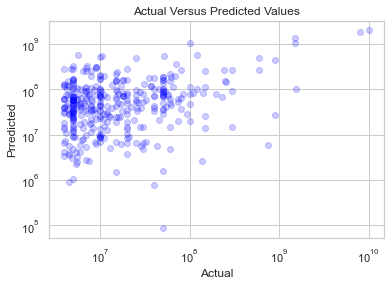

In [17]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

16


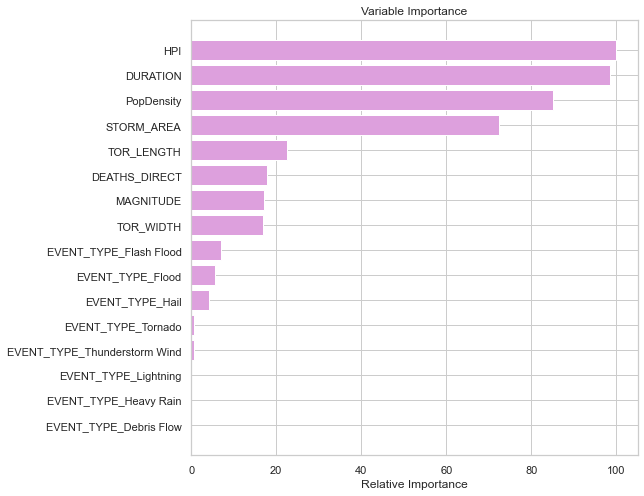

In [18]:
feature_importance = lgbm_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>XGBoost</font>


In [19]:
# define the model
xgbr = XGBRegressor(random_state=1234, early_stopping_rounds=20)
xgbr.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = xgbr.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[0]	validation_0-rmse:271573004.85590	validation_1-rmse:496093808.16381
[1]	validation_0-rmse:225461760.90935	validation_1-rmse:417908785.68289
[2]	validation_0-rmse:189875890.06175	validation_1-rmse:367926331.14018
[3]	validation_0-rmse:162137680.08538	validation_1-rmse:339504851.44559
[4]	validation_0-rmse:142779081.76203	validation_1-rmse:310745803.63487
[5]	validation_0-rmse:125232510.99930	validation_1-rmse:301921762.46121
[6]	validation_0-rmse:112555278.69555	validation_1-rmse:302925936.52804
[7]	validation_0-rmse:102438133.61252	validation_1-rmse:304097852.06160
[8]	validation_0-rmse:93812492.10472	validation_1-rmse:304678025.91454
[9]	validation_0-rmse:86376741.60299	validation_1-rmse:305995794.47720
[10]	validation_0-rmse:80495705.84888	validation_1-rmse:306653690.09471
[11]	validation_0-rmse:75627516.28862	validation_1-rmse:307260483.63865
[12]	validation_0-rmse:71167229.55923	validation_1-rmse:307995101.53959
[13]	validation_0-rmse:67328325.23140	validation_1-rmse:308493479.

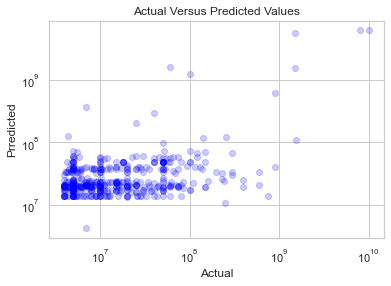

In [20]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

16


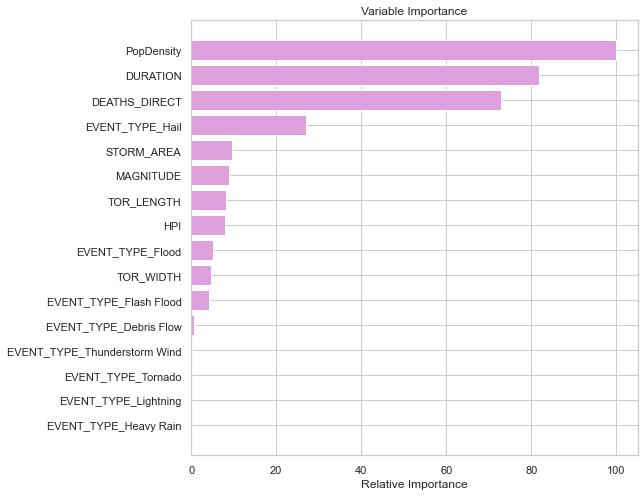

In [21]:
feature_importance = xgbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [22]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'colsample_bytree': [.3, .5, .8],
    'subsample': [.3, .5, .8]
}

In [23]:
# %%time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(XGBRegressor(random_state=1234),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel(), eval_set=eval_set)
# print(random_search.best_estimator_)

In [24]:
# define the model
xgbr_cv = XGBRegressor(random_state=1234,
                       learning_rate=0.1, 
                       max_depth=6, 
                       n_estimators=150,
                       colsample_bytree=.8,
                       subsample=.8)

xgbr_cv.fit(X_train, y_train, eval_set=eval_set)

y_pred = xgbr_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)

print("")
y_pred = xgbr_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")

[0]	validation_0-rmse:318821754.16638	validation_1-rmse:608206838.76415
[1]	validation_0-rmse:300050730.29095	validation_1-rmse:607954356.98433
[2]	validation_0-rmse:289701264.94552	validation_1-rmse:607301898.33586
[3]	validation_0-rmse:272699002.46237	validation_1-rmse:573468977.45477
[4]	validation_0-rmse:257639583.54142	validation_1-rmse:568562337.97495
[5]	validation_0-rmse:254924104.97532	validation_1-rmse:563519358.83179
[6]	validation_0-rmse:240145521.67194	validation_1-rmse:535855793.10835
[7]	validation_0-rmse:227358446.89791	validation_1-rmse:509438133.21110
[8]	validation_0-rmse:216135488.06865	validation_1-rmse:485414034.16201
[9]	validation_0-rmse:205057697.71272	validation_1-rmse:485277126.96205
[10]	validation_0-rmse:194905004.46186	validation_1-rmse:465378909.33452
[11]	validation_0-rmse:185741311.87313	validation_1-rmse:447150169.26396
[12]	validation_0-rmse:179321917.92001	validation_1-rmse:445461550.75411
[13]	validation_0-rmse:174273009.31758	validation_1-rmse:4458

[114]	validation_0-rmse:39581141.21233	validation_1-rmse:343826682.03001
[115]	validation_0-rmse:39385082.40239	validation_1-rmse:343508108.62314
[116]	validation_0-rmse:39155877.63434	validation_1-rmse:343641664.02064
[117]	validation_0-rmse:38971647.09506	validation_1-rmse:343795593.83153
[118]	validation_0-rmse:38772199.30343	validation_1-rmse:343796968.72381
[119]	validation_0-rmse:38585583.78980	validation_1-rmse:343827824.42312
[120]	validation_0-rmse:38415039.21740	validation_1-rmse:343752386.24069
[121]	validation_0-rmse:38230862.60372	validation_1-rmse:343785338.78007
[122]	validation_0-rmse:37965097.26842	validation_1-rmse:343811753.00681
[123]	validation_0-rmse:37840279.35932	validation_1-rmse:343703974.43030
[124]	validation_0-rmse:37645470.44477	validation_1-rmse:343669949.89941
[125]	validation_0-rmse:37540285.62967	validation_1-rmse:343693309.22418
[126]	validation_0-rmse:37449175.65266	validation_1-rmse:343801077.40019
[127]	validation_0-rmse:37329979.20418	validation_1

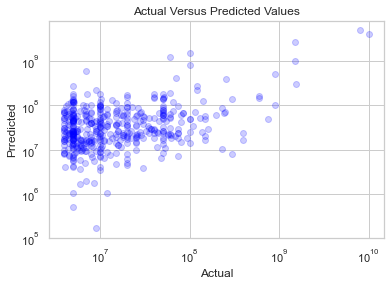

In [25]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show();

16


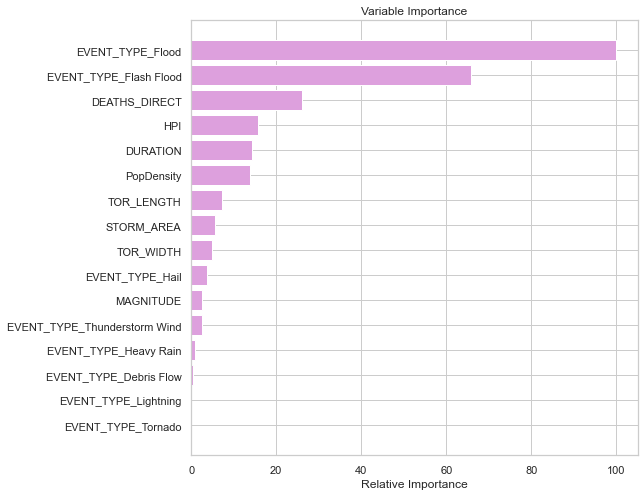

In [26]:
feature_importance = xgbr_cv.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:20]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'plum')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# <font color='orange'>Tweedie Regression</font>


Steps:
- Filter out claims with zero amount, as the severity model requires strictly positive target values.
- Correct for unreasonable observations (that might be data error) and a few exceptionally large claim amounts
    

In [27]:
# load the data - this dataset has the zeroes eliminated
### comment out since current run doesn't contain any zeroes nor outliers
# X_train = pd.read_parquet("../Data/X_train_td.pqt")
# X_test = pd.read_parquet("../Data/X_test_td.pqt")
# y_train = pd.read_parquet("../Data/y_train_td.pqt") 
# y_test = pd.read_parquet("../Data/y_test_td.pqt")

# X = pd.concat([X_train, X_test])
# y = pd.concat([y_train, y_test])

In [28]:
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg = TweedieRegressor(max_iter=500)
tdrg.fit(X_train, y_train.values.ravel())
# make predictions for test data
y_pred = tdrg.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
#train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
#test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
#print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

TRAIN:
MAE:  65,569,474.4
MSE:  101,240,831,693,627,408.0
RMSE: 318,183,644.6
MAPE:  4.5

TEST:
MAE:  93,167,983.0
MSE:  344,164,288,986,059,520.0
RMSE: 586,655,170.4
MAPE:  4.2

MAE DIFF: 42%


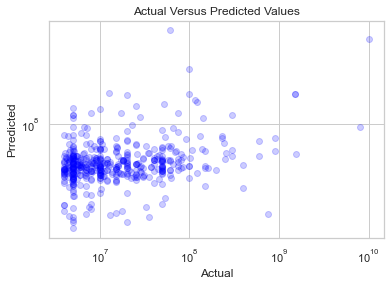

In [29]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [30]:
param_grid = {
    'power': [0, 1, 2, 3],
    'max_iter': [50, 100, 150, 200, 250, 500, 1000, 1500]
}

In [31]:
# %time
# markdown since it takes so long to run
# random_search = RandomizedSearchCV(linear_model.TweedieRegressor(),
#                                    param_grid, n_jobs=-1)
# random_search.fit(X_train, y_train.values.ravel())
# print(random_search.best_estimator_)

In [32]:
#tdrg_cv = TweedieRegressor(link='log', power=3, max_iter=50)
# tdrg = linear_model.TweedieRegressor(max_iter=500)
tdrg_cv = TweedieRegressor(link='log', power=1, max_iter=50)
tdrg_cv.fit(X_train, y_train.values.ravel())

# make predictions for test data
y_pred = tdrg_cv.predict(X_train)
print('TRAIN:')
print('MAE: ', f"{mean_absolute_error(y_train, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_train, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_train, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_train, y_pred):,.1f}")
train_mae = mean_absolute_error(y_train, y_pred)
#train_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
y_pred = tdrg_cv.predict(X_test)
print('TEST:')
print('MAE: ', f"{mean_absolute_error(y_test, y_pred):,.1f}")
print('MSE: ', f"{mean_squared_error(y_test, y_pred):,.1f}")
print('RMSE:', f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.1f}")
print('MAPE: ', f"{mean_absolute_percentage_error(y_test, y_pred):,.1f}")
test_mae = mean_absolute_error(y_test, y_pred)
#test_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("")
print('MAE DIFF:', f"{((test_mae / train_mae) - 1):.0%}")
#print('RMSE DIFF:', f"{((test_rmse / train_rmse) - 1):.0%}")

TRAIN:
MAE:  65,529,606.3
MSE:  101,089,724,865,279,440.0
RMSE: 317,946,103.7
MAPE:  4.3

TEST:
MAE:  94,697,281.4
MSE:  349,791,464,980,630,912.0
RMSE: 591,431,707.8
MAPE:  4.3

MAE DIFF: 45%


/Users/gregwelliver/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


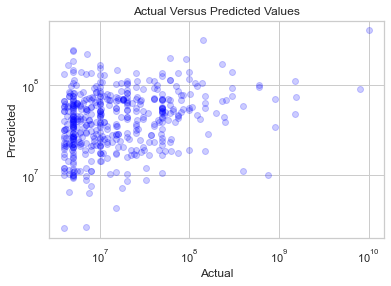

In [33]:
plt.scatter(y_test, y_pred, color = 'blue', alpha=0.2)
plt.title('Actual Versus Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Prredicted')
plt.xscale("log")
plt.yscale("log")
plt.show()